<a href="https://colab.research.google.com/github/Ismail-therap/NLP-Project-Predicting-review-in-1-to-5-star-/blob/main/CNN_and_Hybrid_of_CNN%2BLSTM_in_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
# Importing libraries
import h5py as h5
import scipy.io as sio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from tensorflow.keras.preprocessing import sequence
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Embedding, Dropout, Activation, Reshape
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, GlobalAveragePooling1D, TimeDistributed
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Loading the data

In [43]:

url='https://drive.google.com/file/d/1-vBpWV0H0cxX5jSeHlQIKXIiosMKwq2t/view?usp=sharing'
file_id=url.split('/')[-2]
dwn_url='https://drive.google.com/uc?id=' + file_id
data = pd.read_csv(dwn_url)

# Truncating data

In [44]:
trunc = 500

## sampling neutral review:
reviews1 = data[data["review_stars"] == 1]
reviews1 = reviews1.sample(n=trunc)

## sampling negative review:
reviews2 = data[data["review_stars"] == 2]
reviews2 = reviews2.sample(n=trunc)


## sampling positive review:
reviews3 = data[data["review_stars"] == 3]
reviews3 = reviews3.sample(n=trunc)

## sampling positive review:
reviews4 = data[data["review_stars"] == 4]
reviews4 = reviews4.sample(n=trunc)

## sampling positive review:
reviews5 = data[data["review_stars"] == 5]
reviews5 = reviews5.sample(n=trunc)

data = reviews1.append([reviews2, reviews3,reviews4,reviews5])
data.shape

(2500, 18)

# Text processing for CNN+LSTM hybrid model





In [45]:
from sklearn.model_selection import train_test_split
data['cnn_star'] = data['stars'] - 1
review = data['text'].values
label = data['cnn_star'].values
review_train, review_test, label_train, label_test = train_test_split(review, label, test_size=0.25, random_state=1000)

#num_classes = 5
#at_label_train = k.utils.to_categorical(label_train, num_classes)
#at_label_test = k.utils.to_categorical(label_test, num_classes)


from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(review_train)
Xcnn_train = tokenizer.texts_to_sequences(review_train)
Xcnn_test = tokenizer.texts_to_sequences(review_test)
vocab_size = len(tokenizer.word_index) + 1  


from keras.preprocessing.sequence import pad_sequences
maxlen = 450
Xcnn_train = pad_sequences(Xcnn_train, padding='post', maxlen=maxlen)
Xcnn_test = pad_sequences(Xcnn_test, padding='post', maxlen=maxlen)
print(Xcnn_train[0, :]) 

[   3   13   16   10   19    4 2395   13    3   55 2635  112    3   23
    7  627 4003    2  740   20    4   86 3372    5    4  771   26    1
  361   61    3  257    6   33   25   88  196  110    5  465    1 4004
    2   33   25   88  196 4992   20    1 2395    1 2396    6   70   39
    4 4005    2   23 1057  366    3 2933   12 4993  967   13    3   96
 4006   14  367 2636   25  140   19 2637    1  771   26    1  273    6
   86   14   19  237    1   11   12  907  140  466  141    5   81   16
 4004   35    8   23 4994  727  184   50    4  192    7   51    2  149
   18   24  196 4992    2 2934    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

# Hybrid (CNN + LSTM)

## 5 category prediction

In [46]:
# create the model
embedding_dim = 100
model = Sequential()
model.add(Embedding(vocab_size,embedding_dim, input_length=maxlen))
model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(LSTM(units=128))
model.add(Dense(5,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])

In [47]:
import time
start = time.time()


batch_size = 64
X_train1 = Xcnn_train[batch_size:]
y_train1 = label_train[batch_size:]
X_valid = Xcnn_train[:batch_size]
y_valid = label_train[:batch_size]

history = model.fit(X_train1, y_train1,epochs=10, validation_data=(X_valid, y_valid),batch_size = batch_size)
loss, accuracy = model.evaluate(Xcnn_train, label_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(Xcnn_test, label_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)


print("Execution time: "+"{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

Epoch 1/10
29/29 [==============================] - 16s 443ms/step - loss: 1.2440 - accuracy: 0.2579 - val_loss: 1.2381 - val_accuracy: 0.3906
Epoch 2/10
29/29 [==============================] - 15s 525ms/step - loss: 1.1445 - accuracy: 0.2474 - val_loss: 1.2339 - val_accuracy: 0.1406
Epoch 3/10
29/29 [==============================] - 12s 418ms/step - loss: 1.1233 - accuracy: 0.2402 - val_loss: 1.2279 - val_accuracy: 0.2656
Epoch 4/10
29/29 [==============================] - 11s 372ms/step - loss: 1.0413 - accuracy: 0.2430 - val_loss: 1.3647 - val_accuracy: 0.1406
Epoch 5/10
29/29 [==============================] - 11s 370ms/step - loss: 0.9252 - accuracy: 0.2783 - val_loss: 1.5869 - val_accuracy: 0.3125
Epoch 6/10
29/29 [==============================] - 11s 370ms/step - loss: 0.8006 - accuracy: 0.2954 - val_loss: 1.7563 - val_accuracy: 0.3281
Epoch 7/10
29/29 [==============================] - 11s 370ms/step - loss: 0.7316 - accuracy: 0.3341 - val_loss: 1.8933 - val_accuracy: 0.3281

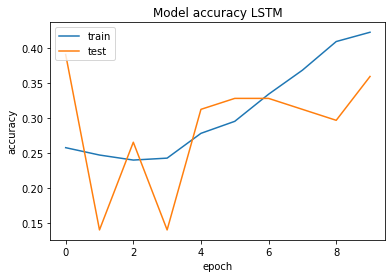

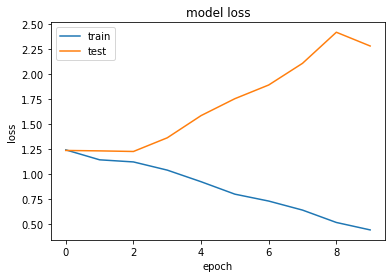

In [48]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy LSTM')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#

# 3 category prediction

In [49]:
import numpy as np

# create a list of our conditions
conditions = [
    (data['review_stars'] <= 2),
    (data['review_stars'] == 3),
    (data['review_stars'] > 3)
    ]

# create a list of the values we want to assign for each condition
values = [0,1,2]

# create a new column and use np.select to assign values to it using our lists as arguments
data['three_star'] = np.select(conditions, values)


# display updated DataFrame
#data.head()

In [50]:
reviews_smallest = data[data["three_star"] == 1]

## sampling negative review:
reviews_neg = data[data["three_star"] == 0]
reviews_neg = reviews_neg.sample(n=reviews_smallest.shape[0])


## sampling positive review:
reviews_pos = data[data["three_star"] == 2]
reviews_pos = reviews_pos.sample(n=reviews_smallest.shape[0])

data = reviews_smallest.append([reviews_neg, reviews_pos])
data.shape

(1500, 20)

In [51]:
trunc = 500

## sampling neutral review:
reviews_utral = data[data["three_star"] == 1]
reviews_utral = reviews_utral.sample(n=trunc)

## sampling negative review:
reviews_neg = data[data["three_star"] == 0]
reviews_neg = reviews_neg.sample(n=trunc)


## sampling positive review:
reviews_pos = data[data["three_star"] == 2]
reviews_pos = reviews_pos.sample(n=trunc)

data = reviews_utral.append([reviews_neg, reviews_pos])
data.shape

(1500, 20)

In [52]:
review = data['text'].values
label = data['three_star'].values
review_train, review_test, label_train, label_test = train_test_split(review, label, test_size=0.25, random_state=1000)

#num_classes = 5
#at_label_train = k.utils.to_categorical(label_train, num_classes)
#at_label_test = k.utils.to_categorical(label_test, num_classes)


from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(review_train)
Xcnn_train = tokenizer.texts_to_sequences(review_train)
Xcnn_test = tokenizer.texts_to_sequences(review_test)
vocab_size = len(tokenizer.word_index) + 1  


from keras.preprocessing.sequence import pad_sequences
maxlen = 450
Xcnn_train = pad_sequences(Xcnn_train, padding='post', maxlen=maxlen)
Xcnn_test = pad_sequences(Xcnn_test, padding='post', maxlen=maxlen)
print(Xcnn_train[0, :]) 

[  38   86   99    3   69   64   41    9   75 2476   14    3   94    9
   57 2477    3    6  167   13  243   53   18  904    2    8   81   14
   15   24   38   86  803   30  143    5  833    8   17   39  305    5
 1444   30    4  953    7  449    3   81  213   94   55    1  164  125
   79 3720   13  804    2    6   10    2   39   38  553    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [53]:
# create the model
embedding_dim = 100
model = Sequential()
model.add(Embedding(vocab_size,embedding_dim, input_length=maxlen))
model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(LSTM(units=128))
model.add(Dense(3,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])

In [55]:
import time
start = time.time()


batch_size = 64
X_train1 = Xcnn_train[batch_size:]
y_train1 = label_train[batch_size:]
X_valid = Xcnn_train[:batch_size]
y_valid = label_train[:batch_size]

history = model.fit(X_train1, y_train1,epochs=10, validation_data=(X_valid, y_valid),batch_size = batch_size)
loss, accuracy = model.evaluate(Xcnn_train, label_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(Xcnn_test, label_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)


print("Execution time: "+"{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

Epoch 1/10
17/17 [==============================] - 8s 453ms/step - loss: 0.0100 - accuracy: 0.9972 - val_loss: 1.6050 - val_accuracy: 0.7344
Epoch 2/10
17/17 [==============================] - 6s 371ms/step - loss: 0.0182 - accuracy: 0.9972 - val_loss: 1.5714 - val_accuracy: 0.7344
Epoch 3/10
17/17 [==============================] - 6s 369ms/step - loss: 0.0079 - accuracy: 0.9991 - val_loss: 1.6500 - val_accuracy: 0.7344
Epoch 4/10
17/17 [==============================] - 6s 369ms/step - loss: 0.0071 - accuracy: 0.9991 - val_loss: 1.6568 - val_accuracy: 0.7656
Epoch 5/10
17/17 [==============================] - 6s 368ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.7019 - val_accuracy: 0.7500
Epoch 6/10
17/17 [==============================] - 6s 370ms/step - loss: 9.4207e-04 - accuracy: 1.0000 - val_loss: 1.7382 - val_accuracy: 0.7344
Epoch 7/10
17/17 [==============================] - 6s 370ms/step - loss: 7.3917e-04 - accuracy: 1.0000 - val_loss: 1.7618 - val_accuracy: 0.734

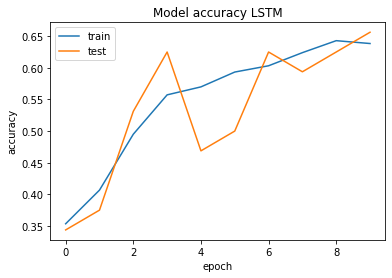

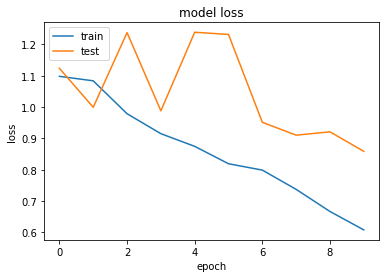

In [32]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy LSTM')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Two category prediction

In [66]:
data = pd.read_csv(dwn_url)

# create a list of our conditions
conditions = [
    (data['review_stars'] <= 2),
    (data['review_stars'] == 3),
    (data['review_stars'] > 3)
    ]

# create a list of the values we want to assign for each condition
values = [0,-1,1]

# create a new column and use np.select to assign values to it using our lists as arguments
data['two_star'] = np.select(conditions, values)


data = data[data.two_star != -1]

# display updated DataFrame
data.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,user_id,review_stars,text,date,two_star
0,0tGuFBrhM03I6TCLxDQhyg,Dancing Goats Coffee Bar,419 W Ponce De Leon Ave,Decatur,GA,30030,33.775805,-84.303269,4.0,358,1,"{'RestaurantsPriceRange2': '1', 'WiFi': ""'free...","Food, Coffee & Tea, Restaurants, Donuts, Cafes","{'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...",IqUD0yoRq66PqnbSvRb5JA,1,OMG!! Hate! This place. Rude to me. On so many...,2018-10-06 14:34:51,0
1,498F3rnpng6qv53S9diTSw,Boston Market,"4607 Braker Ln, Ste 100",Austin,TX,78759,30.399832,-97.744997,3.0,102,1,"{'BusinessAcceptsCreditCards': 'True', 'GoodFo...","American (Traditional), Caterers, Chicken Shop...","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",n2eAlOnBo1St1p7MWqBFmg,1,Why bother being open on Thanksgiving if you c...,2019-11-28 20:02:11,0
2,7qBi3FMT2Oz4Jj1hCWwawA,Bea's Nail Salon,75 Blossom Ct,Boston,MA,02114,42.364891,-71.066818,3.0,23,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Nail Salons, Beauty & Spas","{'Monday': '9:30-19:0', 'Tuesday': '9:30-19:0'...",pHTrbVN4lzTlzqqnWEJYGw,1,"The fact that on a Saturday afternoon this ""sa...",2009-07-11 19:59:46,0
3,K4X4nJVp0BcSn9Cvoavk8A,T'Kilas Tacos & More,1248 Clairmont Rd,Decatur,GA,30030,33.789815,-84.307511,3.0,115,0,"{'GoodForKids': 'True', 'BikeParking': 'False'...","Mexican, Restaurants","{'Monday': '11:0-22:30', 'Tuesday': '11:0-22:3...",Jfc8qYR3uEHIpU0nKzpObg,1,"I came to Los Loros in search of the ""strong, ...",2008-09-08 21:34:50,0
4,D6U1_06gxciRs1NoYjwhKQ,ESPN Club - Temporarily Unavailable,2101 N Epcot Resorts Blvd,Orlando,FL,32836,28.368008,-81.555289,2.5,303,1,"{'GoodForKids': 'True', 'Caters': 'False', 'Re...","Hotels, American (New), Event Planning & Servi...","{'Monday': '0:0-0:0', 'Tuesday': '12:0-23:0', ...",Dw_oka5MVWOsaJCncfIXZQ,1,My fries were stale and my cheesesteak was mos...,2018-01-14 01:41:50,0


In [67]:
trunc = 1000

## sampling negative review:
reviews_neg = data[data["two_star"] == 0]
reviews_neg = reviews_neg.sample(n=trunc)


## sampling positive review:
reviews_pos = data[data["two_star"] == 1]
reviews_pos = reviews_pos.sample(n=trunc)

data = reviews_neg.append([reviews_pos])
data.shape

(2000, 19)

In [68]:
review = data['text'].values
label = data['two_star'].values
review_train, review_test, label_train, label_test = train_test_split(review, label, test_size=0.25, random_state=1000)

#num_classes = 5
#at_label_train = k.utils.to_categorical(label_train, num_classes)
#at_label_test = k.utils.to_categorical(label_test, num_classes)


from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(review_train)
Xcnn_train = tokenizer.texts_to_sequences(review_train)
Xcnn_test = tokenizer.texts_to_sequences(review_test)
vocab_size = len(tokenizer.word_index) + 1  


from keras.preprocessing.sequence import pad_sequences
maxlen = 450
Xcnn_train = pad_sequences(Xcnn_train, padding='post', maxlen=maxlen)
Xcnn_test = pad_sequences(Xcnn_test, padding='post', maxlen=maxlen)
print(Xcnn_train[0, :]) 

[1078 2935  427 1415   13   46    7    1  875  237    4   72    6    4
   40 2936 2937  317   51  253  764   61    3   83    2    8    6   41
  340   16  480   20    5  606  516  677    2    8    6  225   17   21
  985  265    3    6 4365   20    1  530    7    1  317   24   16 2233
    4 1503    1  317    2  281   84    5  217    3   78    1  566  787
  250    2    8    6   73   33   31   85    1 2937  317    6 1416 4366
 1864  726    2   80  385  186   18 1865 2234 2938    3  240    8  146
  742   17    3 1417   13   80   88   95 2235    8  127   18   37  136
  841  187   15   10    5  540  276    3   23    4   84   80  647  540
    2    8    6  287   14  567   44    4  173 2530   20    1  540   64
    6    5   73  105 1025   31   85   45   19  277   81 1504    4   58
  220   11    1 4367  607    9    1 4368    7 2236  541    3  596   44
  254    1 1325  743   65  153    3    6  225   99   74 1253  150    5
 1325  743 1866  156  164    5   34    3   62   27  842   31    3  125
    4 

In [69]:
# create the model
embedding_dim = 100
model = Sequential()
model.add(Embedding(vocab_size,embedding_dim, input_length=maxlen))
model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(LSTM(units=128))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer = 'adam',metrics = ['accuracy'])

In [70]:
import time
start = time.time()


batch_size = 64
X_train1 = Xcnn_train[batch_size:]
y_train1 = label_train[batch_size:]
X_valid = Xcnn_train[:batch_size]
y_valid = label_train[:batch_size]

history = model.fit(X_train1, y_train1,epochs=10, validation_data=(X_valid, y_valid),batch_size = batch_size)
loss, accuracy = model.evaluate(Xcnn_train, label_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(Xcnn_test, label_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)


print("Execution time: "+"{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

Epoch 1/10
23/23 [==============================] - 11s 395ms/step - loss: 0.6871 - accuracy: 0.5299 - val_loss: 0.6947 - val_accuracy: 0.5312
Epoch 2/10
23/23 [==============================] - 9s 371ms/step - loss: 0.6227 - accuracy: 0.6532 - val_loss: 0.6735 - val_accuracy: 0.7031
Epoch 3/10
23/23 [==============================] - 9s 370ms/step - loss: 0.3675 - accuracy: 0.8510 - val_loss: 0.5258 - val_accuracy: 0.7812
Epoch 4/10
23/23 [==============================] - 9s 371ms/step - loss: 0.1031 - accuracy: 0.9714 - val_loss: 0.4990 - val_accuracy: 0.7812
Epoch 5/10
23/23 [==============================] - 9s 369ms/step - loss: 0.0402 - accuracy: 0.9882 - val_loss: 0.6355 - val_accuracy: 0.7969
Epoch 6/10
23/23 [==============================] - 8s 368ms/step - loss: 0.0487 - accuracy: 0.9840 - val_loss: 0.6044 - val_accuracy: 0.8281
Epoch 7/10
23/23 [==============================] - 8s 368ms/step - loss: 0.0089 - accuracy: 0.9993 - val_loss: 0.5227 - val_accuracy: 0.8438
Epoch

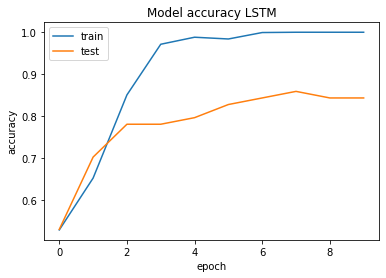

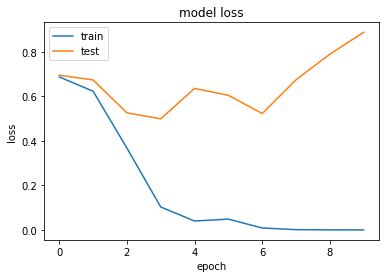

In [71]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy LSTM')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()